In [60]:
!mkdir content

mkdir: content: File exists


In [ ]:
!unzip ./content/Dataset.zip

In [61]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install pillow
!pip3 install scikit-learn
!pip3 install tensorflow
!pip3 install opencv-python
!pip3 install pydot

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [63]:
PATH = 'content/lung_colon_image_set/lung_image_sets/'

IMAGE_CLASSES = os.listdir(PATH)

IMAGE_CLASSES

['lung_aca', 'lung_n', 'lung_scc']

### ACA = Adenocarcinomas
### N = Normal 
### SCC = Squamous Cell Carcinomas

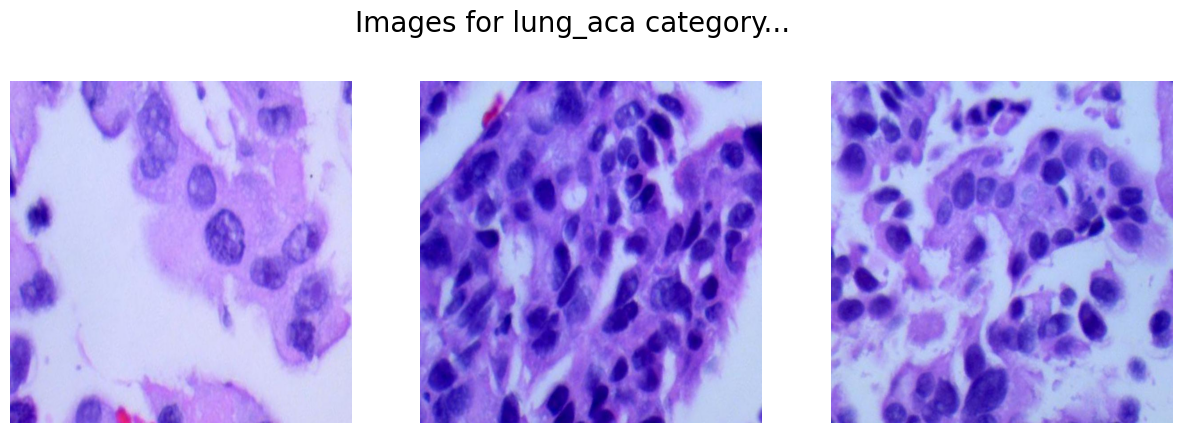

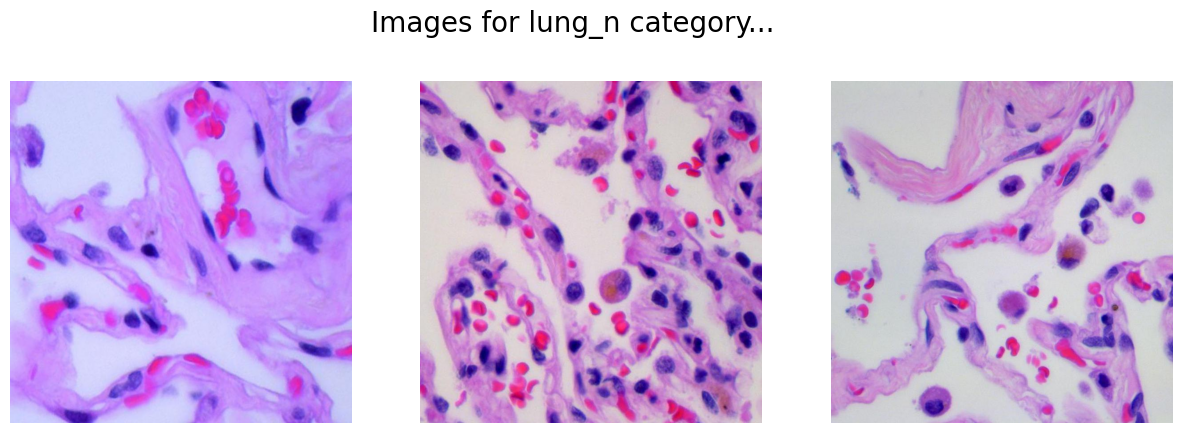

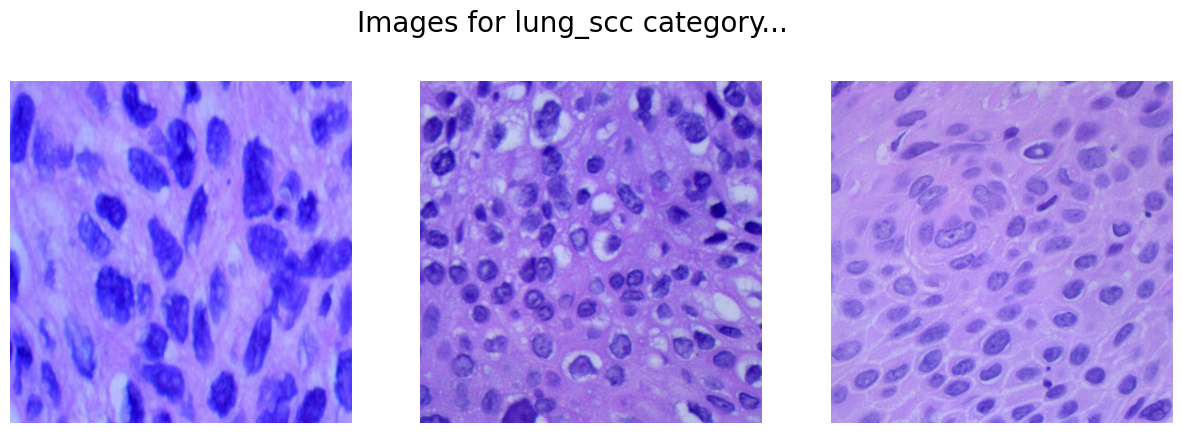

In [64]:
for category in IMAGE_CLASSES:
    image_directory = f'{PATH}/{category}'
    images = os.listdir(image_directory)
    
    figure, ax = plt.subplots(1, 3, figsize=(15, 5))
    figure.suptitle(f'Images for {category} category...', fontsize=20)
    
    for i in range(3):
        randon_image_number = np.random.randint(0, len(images))
        image = np.array(Image.open(f'{PATH}/{category}/{images[randon_image_number]}'))
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

### COMPUTER VISION CONSTANTS OR MODEL HYPERPARAMETERS

In [65]:
IMAGE_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

### SPLIT DATA AND ENCODING

In [66]:
X = []
Y = []

for i, category in enumerate(IMAGE_CLASSES):
    images = glob(f'{PATH}/{category}/*.jpeg')
    
    for image in images: 
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_y = pd.get_dummies(Y).values

In [67]:
x_train, x_value, y_train, y_value = train_test_split(X, one_hot_encoded_y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(x_train.shape, x_value.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


### CNN Model

In [68]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMAGE_SIZE,
                               IMAGE_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

### SUMMARY OF MODEL ARCHITECTURE

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 128)     

In [70]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [71]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [72]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
early_stopping = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
learning_rate = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [73]:
history = model.fit(x_train, y_train,
                    validation_data = (x_value, y_value),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [early_stopping, learning_rate, myCallback()])

Epoch 1/10
188/188 [==============================] - 674s 4s/step - loss: 0.3817 - accuracy: 0.8421 - val_loss: 3.6559 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 679s 4s/step - loss: 0.2622 - accuracy: 0.8963 - val_loss: 0.4761 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 671s 4s/step - loss: 0.1784 - accuracy: 0.9268 - val_loss: 0.7718 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9409
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 676s 4s/step - loss: 0.1413 - accuracy: 0.9409 - val_loss: 0.9407 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 694s 4s/step - loss: 0.0884 - accuracy: 0.9678 - val_loss: 2.5787 - val_accuracy: 0.6853 - lr: 5.0000e-04


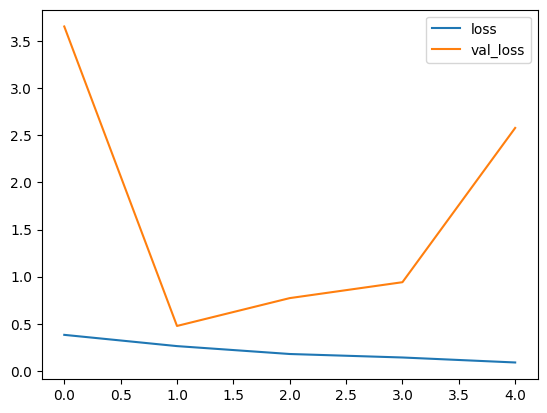

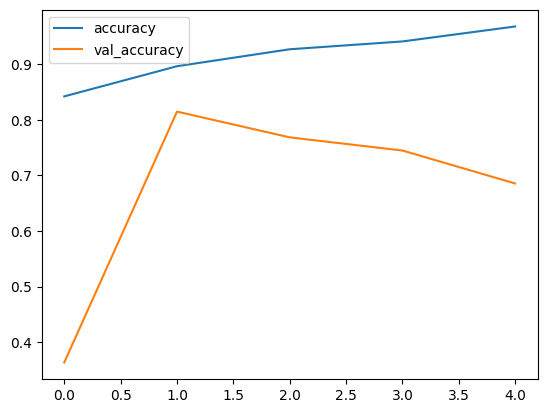

In [80]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [75]:
y_prediction = model.predict(x_value)
y_value = np.argmax(y_value, axis=1)
y_prediction = np.argmax(y_prediction, axis=1)

94/94 [==============================] - 47s 491ms/step


In [76]:
metrics.confusion_matrix(y_value, y_prediction)

array([[473, 154, 360],
       [  0, 977,   0],
       [ 41,   1, 994]])

In [77]:
print(metrics.classification_report(y_value, y_prediction,
                                    target_names=IMAGE_CLASSES))

              precision    recall  f1-score   support

    lung_aca       0.92      0.48      0.63       987
      lung_n       0.86      1.00      0.93       977
    lung_scc       0.73      0.96      0.83      1036

    accuracy                           0.81      3000
   macro avg       0.84      0.81      0.80      3000
weighted avg       0.84      0.81      0.80      3000

